# Classification model for Taiwanese companies bankruptcy
## Introduction
Research and development as well as equity to liability are thought to be important factors in the success of an enterprise, but we were wondering how much it can predict its success. Our research question is as follows: by examining future growth investment through a company’s research and development expenditures, and its total equity growth, might one be able to form a reliable predictive model indicating whether or not it is likely to go bankrupt in the near future?

To answer this question, we have chosen a dataset titled “Taiwanese Bankruptcy Prediction”, compiled by the Taiwanese Economic Journal. This dataset includes quantitative data pertaining to 6819 companies along one main classifier: 0 for solvent, 1 for bankrupt. This data was gathered over a period of ten years from 1999 to 2009, and adds valuable insight to support that bankruptcy can be predicted ahead of time.

In order to predict whether a company is bankrupt or not, we chose to look at two key variables: the development and research expense rate, as well as the equity to liability ratio. The development and research expenses rate provide insight into expentendure into potential growth of companies, while the equity to liability ratio provides an overall comprehensive summary of companies’ financial standing.

Out of 95 possible predictive variables, we chose to examine "Research and Development Expenses" and "Equity to Liability". We thought these were particularly interesting since they pertain to a company’s strategic approach towards future growth.

Our hypothesis is that companies which are investing more capital in forward-looking projects are less likely to go bankrupt, as they will have better-investigated plans for their future trajectories. A preliminary analysis showed that these variables were, in many cases, able to predict the near-future bankruptcy status of a particular observation. This could be valuable information for those invested in companies, as significant predictors to track the future success of a company.

## Methods and results

In [1]:
# Install themis library
install.packages("themis")

# Import necessary libraries
library(tidyverse)
library(tidymodels)
library(themis)
library(janitor)
library(RColorBrewer)

# Set seed
set.seed(123)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── t

In [2]:
# Read dataset into R
# For exploration we are selecting the data we are going to use because there are too many columns
# and renaming all of them here would get long.
download.file("https://raw.githubusercontent.com/GaryHilares/dsci100-2023w1-group00820/main/data.csv",
              "taiwanese_data.csv")
taiwanese_data <- read_csv("taiwanese_data.csv") |>
                  clean_names() |>
                  select(bankrupt, research_and_development_expense_rate, equity_to_liability) |>
                  mutate(bankrupt = recode(as.factor(bankrupt), "0" = "No", "1" = "Yes")) |>
                  drop_na()
head(taiwanese_data)

Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,research_and_development_expense_rate,equity_to_liability
<fct>,<dbl>,<dbl>
Yes,0,0.01646874
Yes,0,0.02079431
Yes,25500000,0.01647411
Yes,0,0.02398233
Yes,0,0.03549020
Yes,0,0.01953448


In [3]:
taiwanese_split <- initial_split(taiwanese_data, prop = 0.75, strat = bankrupt)
taiwanese_training <- training(taiwanese_split)
taiwanese_testing <- testing(taiwanese_split)

In [4]:
# Summarize the amount of observations that we have per each label
taiwanese_training |> group_by(bankrupt) |> summarize(count = n())

bankrupt,count
<fct>,<int>
No,4941
Yes,173


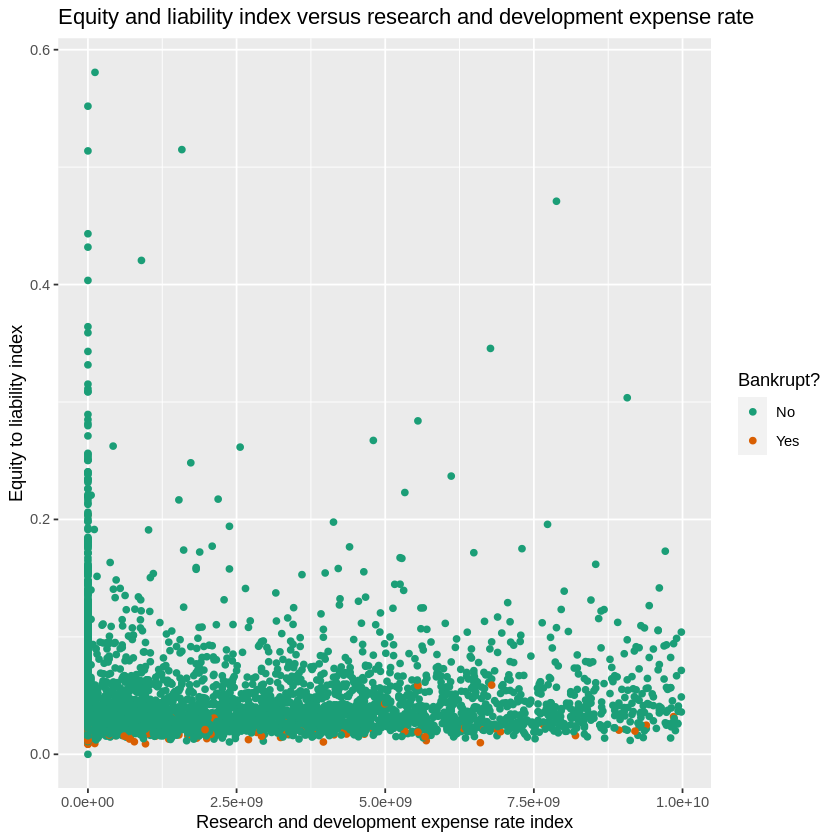

In [5]:
taiwanese_training |> ggplot(aes(x = research_and_development_expense_rate,
                                 y = equity_to_liability,
                                 color = bankrupt)) +
                      geom_point() +
                      labs(title = "Equity and liability index versus research and development expense rate",
                           x = "Research and development expense rate index",
                           y = "Equity to liability index",
                           color = "Bankrupt?") +
                      scale_color_brewer(palette = "Dark2")

In [6]:
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))
taiwanese_folds <- taiwanese_training |> vfold_cv(v = 5, strata = bankrupt)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
taiwanese_recipe <- recipe(bankrupt ~ research_and_development_expense_rate + equity_to_liability,
                           data = taiwanese_training) |>
                    step_downsample(bankrupt, under_ratio = 1, skip = TRUE) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())
taiwanese_metrics <- workflow() |>
                     add_recipe(taiwanese_recipe) |>
                     add_model(knn_spec) |>
                     tune_grid(resamples = taiwanese_folds, grid = k_vals) |>
                     collect_metrics()

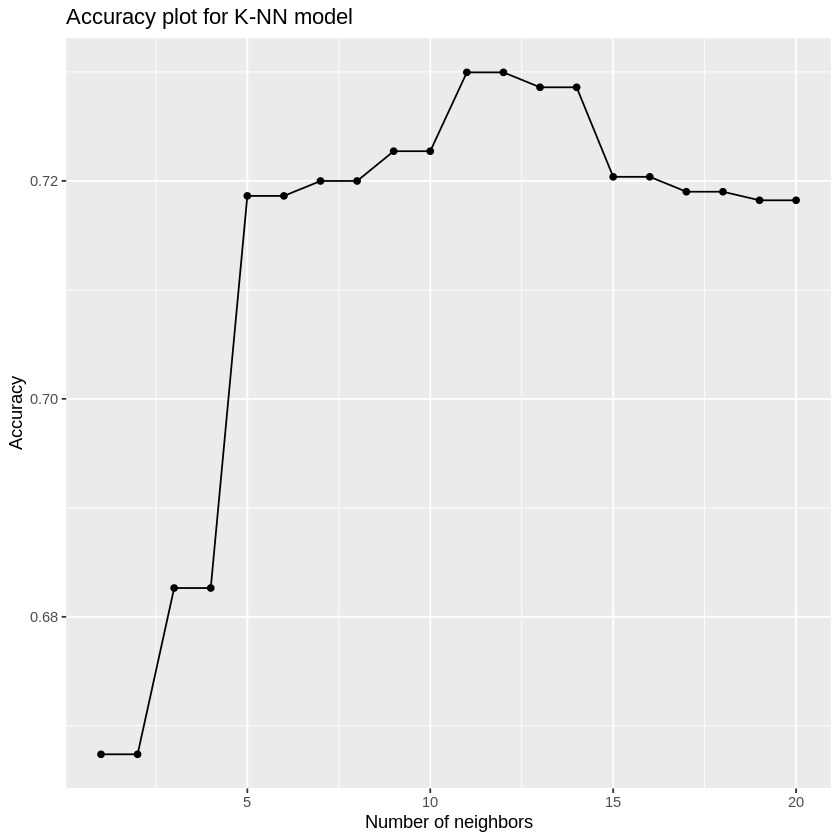

In [7]:
taiwanese_metrics |> filter(.metric == "accuracy") |>
                     select(neighbors, mean) |>
                     ggplot(aes(x = neighbors, y = mean)) +
                     geom_line() +
                     geom_point() +
                     labs(title = "Accuracy plot for K-NN model",
                          x = "Number of neighbors",
                          y = "Accuracy")

In [10]:
best_k <- taiwanese_metrics |> arrange(-mean) |> select(neighbors) |> slice(1) |> pull()
taiwanese_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                  set_engine("kknn") |>
                  set_mode("classification")
taiwanese_fit <- workflow() |>
                 add_recipe(taiwanese_recipe) |>
                 add_model(taiwanese_spec) |>
                 fit(taiwanese_training)
taiwanese_predictions <- taiwanese_fit |>
                         predict(taiwanese_testing) |>
                         select(.pred_class) |>
                         bind_cols(taiwanese_testing)
head(taiwanese_predictions)

.pred_class,bankrupt,research_and_development_expense_rate,equity_to_liability
<fct>,<fct>,<dbl>,<dbl>
Yes,Yes,2.55e+07,0.01647411
Yes,Yes,0.00e+00,0.02398233
Yes,No,7.30e+08,0.01566307
No,No,5.09e+07,0.03488856
No,No,0.00e+00,0.03080087
No,No,1.90e+09,0.03657169


In [9]:
taiwanese_predictions |> metrics(truth = bankrupt, estimate = .pred_class)
taiwanese_predictions |> conf_mat(truth = bankrupt, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7653959
kap,binary,0.1302596


          Truth
Prediction   No  Yes
       No  1263    5
       Yes  395   42

## Discussion
## References